In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(18169, 28)
(18169, 3)


In [6]:
X_motion_CoM_continuous[0]

array([0.10000000149, 0.0, 0.0, -0.00496986204793, -0.00408022931429,
       -0.00109604628434, 0.00122067253564, -0.000711765578059,
       -0.00625571855141, 0.200121728837, 0.166996461348, 0.0264265283995,
       0.204089168697, -0.174598457706, 0.0264295076605, -0.273436766637,
       0.1667372319, 0.0264338022838, -0.277341491648, -0.174495762964,
       0.02643734995, True, False, False, True, 0.10000000149, 0.0, 0.0],
      dtype=object)

In [7]:
Y_motion_CoM_continuous[0]

array([0.008734794643757763, -0.005649023130472182,
       2.5159014796704302e-05], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 22] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(9048, 28)
(9048, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_FR_RL[0, :]

array([0.10000000149, 0.0, 0.0, -0.000890185791332, -0.00484342625699,
       -0.0016179894701, -0.00407560999425, -0.00107515501585,
       -0.00510968513852, 106.788537736, 0.10975357348, 0.0264453367638,
       106.792137872, -0.219981122143, 0.0264500947938, 106.312148598,
       0.108510310608, 0.0264116215657, 106.309447442, -0.219160371546,
       0.0264162702676, False, True, True, False, 0.10000000149, 0.0, 0.0],
      dtype=object)

In [11]:
Y_motion_CoM_FR_RL[0, :]

array([0.008710594356770684, -0.005823853354034292,
       0.00010580817889640592], dtype=object)

### Linear Regression

In [76]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9571480269713527
RMSE:  0.00908353284339303
The lowest error is:  1.6972547605270671e-06
The highest error is:  0.0488734505116441
The avg. error is:  0.005592722404378275


In [77]:
model_fr_com_x.coef_

array([[ 0.02796967,  0.024182  ,  0.00068058,  0.11790178, -0.0290885 ,
        -0.00077581, -0.0443757 , -0.10942164,  0.08139676,  0.07498781,
        -0.0055743 ,  0.06217922, -0.03144605, -0.02771618]])

In [78]:
model_fr_com_x.intercept_

array([-0.00319576])

In [45]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[0.00706085]]


Text(0, 0.5, 'Predictions')

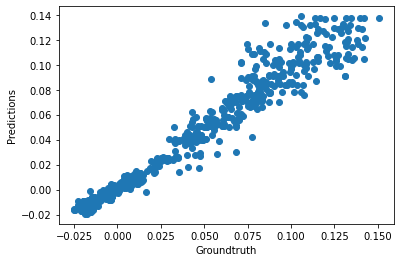

In [46]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [47]:
#%store model_fr_com_x

In [48]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [49]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [50]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9188690504909617
RMSE:  0.008347083339618309
The lowest error is:  1.720861675492437e-06
The highest error is:  0.09165161405770296
The avg. error is:  0.005075455705876333


In [51]:
model_fr_com_y.coef_

array([[ 0.0316049 ,  0.02016423,  0.00060737, -0.02965458,  0.14840231,
        -0.00021702, -0.10546343,  0.00664393,  0.07031531, -0.01054266,
         0.10000394,  0.04083131, -0.06486641, -0.03691823]])

In [52]:
model_fr_com_y.intercept_

array([-3.7114816e-05])

Text(0, 0.5, 'Predictions')

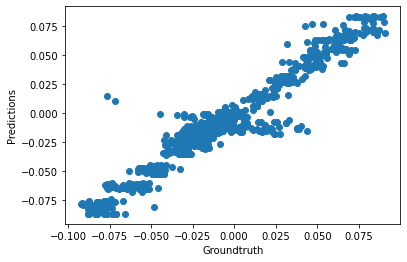

In [53]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [54]:
#%store model_fr_com_y

In [55]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [56]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")

## Predict CoM -> Yaw

In [61]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # Current motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9344307722624985
RMSE:  0.006078763492400729
The lowest error is:  4.0131859732508816e-07
The highest error is:  0.1504286885196181
The avg. error is:  0.0016806973836228382


In [62]:
model_fl_com_theta.coef_

array([[-0.00223515,  0.00241875,  0.10491453,  0.00301203, -0.00138445,
         0.03028244, -0.01196371, -0.00544019,  0.02164832, -0.00214386,
         0.00095218, -0.00818043, -0.01063611,  0.01576387]])

In [63]:
model_fl_com_theta.intercept_

array([-0.00011146])

Text(0, 0.5, 'Predictions')

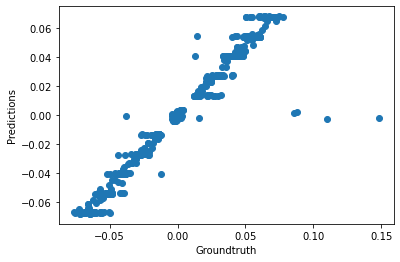

In [64]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")